In [4]:
CLONE_URL = f"https://github.com/RojanRegmi/adaIN.git"
get_ipython().system(f"git clone {CLONE_URL}")

Cloning into 'adaIN'...
remote: Enumerating objects: 352, done.
remote: Total 352 (delta 0), reused 0 (delta 0), pack-reused 352
Receiving objects: 100% (352/352), 103.73 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [13]:
os.listdir('/kaggle/working/adaIN/')

['torch_to_pytorch.py',
 'results.png',
 '.gitignore',
 'train.py',
 'README.md',
 'function.py',
 '.git',
 'test.py',
 'LICENSE',
 'requirements.txt',
 'input',
 'sampler.py',
 'net.py',
 'models',
 'test_video.py']

### Loading Libraries

In [14]:
import sys
sys.path.append(f'/kaggle/working/adaIN/')

In [15]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image, ImageFile
from tensorboardX import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from pathlib import Path

import net
from sampler import InfiniteSamplerWrapper

ModuleNotFoundError: No module named 'net'

### Setting Parameters

In [59]:
cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

content_dir = "/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1"
style_dir = "/kaggle/input/painter-by-numbers-resized/"

save_dir = "/kaggle/working/"
encoder_path = "/kaggle/input/vgg_normalized/pytorch/1/1/vgg_normalised.pth"

log_dir = "/kaggle/working/adaIN"
os.makedirs(log_dir, exist_ok='True')

writer = SummaryWriter(log_dir=str(log_dir))

lr = 1e-4
lr_decay = 5e-5
max_iter = 160000
batch_size = 8
style_weight = 10
content_weight = 1
n_threads = 4
save_model_interval = 10000

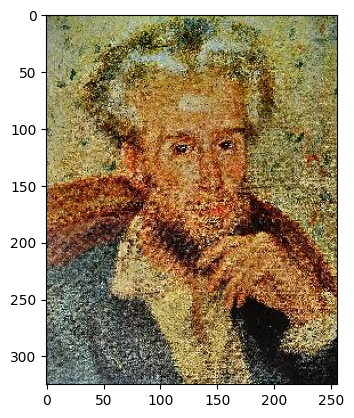

In [13]:
resize_transform = transforms.Resize(size=(32, 32))

image = Image.open('/kaggle/input/painter-by-numbers-resized/100006.jpg').convert('RGB')

# Apply the resize transform
resized_image = resize_transform(image)

# Display the original and resized images
plt.imshow(image)
# plt.imshow(resized_image)
#resized_image.show()


In [9]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Style and Content Dataset and Dataloader

In [50]:
class CIFAR10(data.Dataset):
    def __init__(self, data_dir, train=True, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        
        self.data = []
        self.targets = []
        
        # Load data from the dataset files
        if self.train:
            for batch_id in range(1, 6):
                file_path = os.path.join(data_dir, f'data_batch_{batch_id}')
                with open(file_path, 'rb') as f:
                    entry = pickle.load(f, encoding='bytes')
                    self.data.extend(entry[b'data'])
                    self.targets.extend(entry[b'labels'])
        else:
            file_path = os.path.join(data_dir, 'test_batch')
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='bytes')
                self.data = entry[b'data']
                self.targets = entry[b'labels']
        
        self.data = np.array(self.data, dtype=np.uint8)
        self.targets = np.array(self.targets)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index].reshape(3, 32, 32)
        img = np.transpose(img, (1, 2, 0))
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        target = self.targets[index]
        
        return img

In [51]:
class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

In [52]:
transform_style = transforms.Compose([
    
    transforms.Resize(size=(32, 32)),
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_content = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [53]:
cifar_10_dir = '/kaggle/input/cifar10-python/cifar-10-batches-py/'
content_dataset = CIFAR10(data_dir=cifar_10_dir, train=True, transform=transform_content)

style_dir = '/kaggle/input/painter-by-numbers-resized/'
style_dataset = FlatFolderDataset(root=style_dir, transform=transform_style)

In [54]:
content_iter = iter(data.DataLoader(content_dataset, batch_size=batch_size, sampler=InfiniteSamplerWrapper(content_dataset),num_workers=n_threads))
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=n_threads))

### Training of AdaIN on CIFAR

In [34]:
decoder = net.decoder
vgg = net.vgg

In [36]:
os.listdir('/kaggle/input/vgg_normalized')

['pytorch']

In [ ]:
vgg.load_state_dict(torch.load(encoder_path))
vgg = nn.Sequential(*list(vgg.children())[:31])
network = net.Net(vgg, decoder)
network.train()
network.to(device)

In [48]:
optimizer = torch.optim.Adam(network.decoder.parameters(), lr=lr)

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    learning_rate = lr / (1.0 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [60]:
for i in tqdm(range(max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s = network(content_images, style_images)
    loss_c = content_weight * loss_c
    loss_s = style_weight * loss_s
    loss = loss_c + loss_s

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    writer.add_scalar('loss_content', loss_c.item(), i + 1)
    writer.add_scalar('loss_style', loss_s.item(), i + 1)

    if (i + 1) % save_model_interval == 0 or (i + 1) == max_iter:
        state_dict = net.decoder.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict, save_dir /
                   'decoder_iter_{:d}.pth.tar'.format(i + 1))
writer.close()

  0%|          | 132/160000 [00:48<16:25:17,  2.70it/s]


KeyboardInterrupt: 

In [ ]:
os.listdir('/kaggle/working/')